<a href="https://colab.research.google.com/github/BlackJack2021/Zenn_GradientBoostingIntervalPrediction/blob/main/gradient_boosting_interval_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備
## 必要なライブラリのインストール

In [ ]:
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 5.3 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120341 sha256=e9bab58fba4d8d77daf94c52bb26c57b7844aab975e362837ceeb3639a4eb506
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


## 必要なライブラリのインポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import lightgbm as lgbm
import seaborn as sns

## ダミーデータの作成

In [ ]:
np.random.seed(1)
num_of_sample = 3000

x = np.random.uniform(low=-5, high=5, size=num_of_sample)

# 後のmatplotlibを用いた描画に備えて小さい順に並び替えておく。そうしないと描画がぐちゃぐちゃになる。
x = np.sort(x)

# ground truth (真の値) は sin カーブであるとする。
ground_truth = np.sin(x)
# 目的変数の実際の値は ground truth に誤差が乗った状態で現れる。
# 今回は正規分布に従って誤差が発生すると考えるが、その正規分布の分散は cos カーブの2乗で表現されるものとする。
# 2乗するのは分散にマイナスの値が表れるのを防ぐため。
true_var = np.cos(x)**2
error = np.random.randn(num_of_sample) * np.sqrt(true_var)

# 目的変数の値 = 真の値 + 誤差
y = ground_truth + error

# lightgbm に学習データとして渡すとき用に整形
x_for_lgbm = x.reshape((-1,1))
y_for_lgbm = y.reshape((-1,))

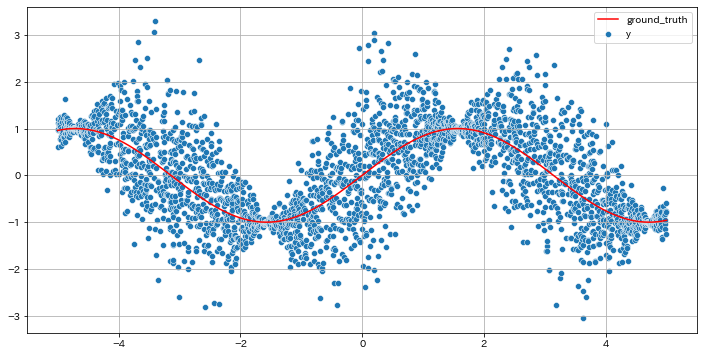

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
sns.scatterplot(
    x=x, y=y, ax=ax, label='y'
)
sns.lineplot(
    x=x, y=ground_truth, ax=ax, label='ground_truth', color='red'
)
ax.grid()
ax.legend()

# 分位点回帰

## pinball loss 関数の可視化

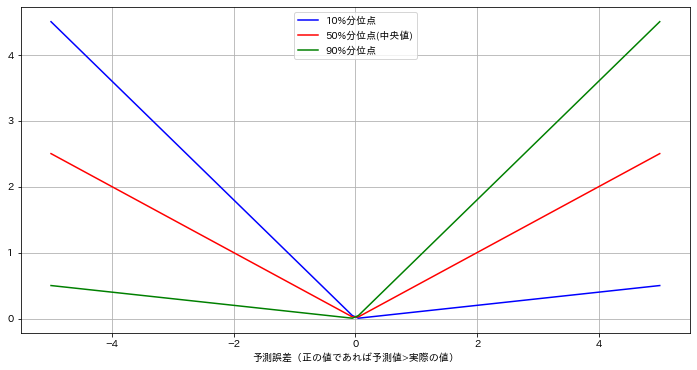

In [ ]:
alphas = [0.1, 0.5, 0.9]
colors = ['blue', 'red', 'green']
labels = ['10%分位点', '50%分位点(中央値)', "90%分位点"]

def get_pinball_loss(y_diff: float, alpha: float):
    if y_diff > 0:
        return y_diff * alpha
    else:
        return -y_diff * (1 - alpha)

y_diffs = np.linspace(-5, 5, 100)
fig, ax = plt.subplots(figsize=(12,6))
for i, alpha in enumerate(alphas):
    color = colors[i]
    label = labels[i]
    pinball_loss = [
        get_pinball_loss(y_diff, alpha) for y_diff in y_diffs 
    ]
    sns.lineplot(
        x=y_diffs, 
        y=pinball_loss, 
        label=label, 
        color=color,
        ax=ax
    )
ax.grid()
ax.set_xlabel('予測誤差（正の値であれば予測値>実際の値）')
fig.show()

## 実装

予測の実装

In [ ]:
lower_quantile = 0.025
upper_quantile = 0.975

predict_dict = {}
for quantile in [lower_quantile, upper_quantile]:
    quantile_params = {
        "objective": "quantile", # quantile を指定することで分位点予測となる。
        "alpha": quantile # alpha には分位点の値を指定する。
    }
    quantile_regressor = lgbm.train(
        quantile_params,
        lgbm.Dataset(x_for_lgbm, y_for_lgbm),
    )
    quantile_predict = quantile_regressor.predict(x_for_lgbm)
    predict_dict[quantile] = quantile_predict

予測区間の描画

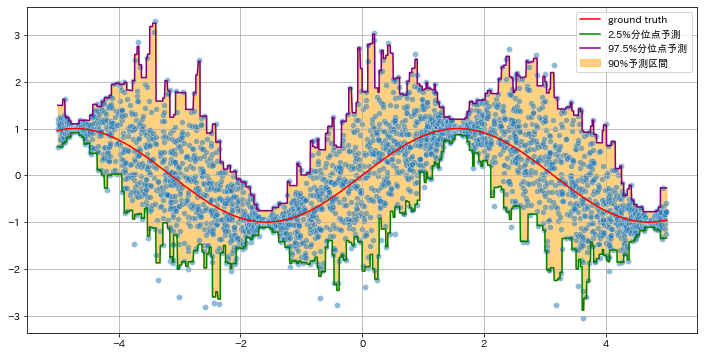

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
# ground truth
ax.plot(x, ground_truth, c='red', label='ground truth')
# 2.5% 分位予測
ax.plot(x, predict_dict[lower_quantile], c='green', label=f'{lower_quantile*100:.1f}%分位点予測')
# 97.5% 分位予測
ax.plot(x, predict_dict[upper_quantile], c='purple', label=f'{upper_quantile*100:.1f}%分位点予測')

# 描画で指定している alpha は透明度です。
ax.fill_between(
    x, 
    predict_dict[lower_quantile],
    predict_dict[upper_quantile],
    color='orange',
    alpha = 0.5,
    label='90%予測区間'
)

sns.scatterplot(x=x,y=y,ax=ax, alpha=0.5)
ax.grid()
ax.legend()
fig.show()

区間に含まれるデータの割合の確認

In [ ]:
upper = predict_dict[upper_quantile]
lower = predict_dict[lower_quantile]
total = 0
for i in range(num_of_sample):
    upper_i = upper[i]
    lower_i = lower[i]
    y_i = y[i]
    # 区間内に含まれたデータの数をカウント
    total += (lower_i <= y_i <= upper_i)

# 割合を計算する。
print(total/num_of_sample)

0.947


# 事後的な予測誤差の当てはめ

In [ ]:
# まず目的変数に対する予測値を導出する。
y_reg_params = {
    "objective": 'regression'
}

y_regressor = lgbm.train(
    y_reg_params,
    lgbm.Dataset(x_for_lgbm, y_for_lgbm)
)

y_pred = y_regressor.predict(x_for_lgbm)

In [ ]:
# 次に、分散推測モデルを構築し、分散の推測を行う。
def grad_hess_for_logvar(log_var: np.ndarray, data: lgbm.Dataset):
    '''
    推測された分散対数値に対する損失の一階微分及び二階微分を導出する
    y_pred については引数としてではなくグローバル変数として与えていることに注意。
    '''
    y_true = data.get_label()
    grad = 1/2 - 1/2 * (y_true - y_pred)**2 / np.exp(log_var)
    hess = 1/2 * (y_true - y_pred)**2 / np.exp(log_var)
    return grad, hess

log_var_reg_params = {
    "objective": "regression"
}

log_var_regressor = lgbm.train(
    log_var_reg_params,
    lgbm.Dataset(x_for_lgbm, y_for_lgbm),
    fobj=grad_hess_for_logvar # fobj 引数に自作の grad, hess 導出関数を定義する。
)
# 推測された標準偏差を導出する。
log_var_pred = log_var_regressor.predict(x_for_lgbm)
std_pred = np.sqrt(np.exp(log_var_pred))

In [ ]:
# 推測された分散から95%区間予測を導出する。
# 謎な場合には https://bellcurve.jp/statistics/course/8888.html などが分かりやすいです。
upper_pred = y_pred + 1.96 * std_pred
lower_pred = y_pred - 1.96 * std_pred

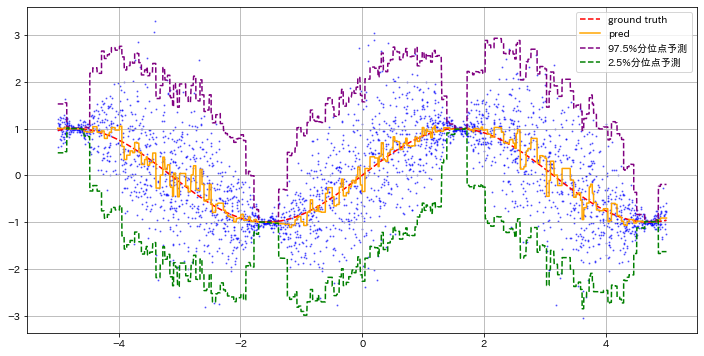

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(x, y, color='blue', s=1, alpha=0.5)
ax.plot(x, ground_truth, color='red', label='ground truth', linestyle='--')
ax.plot(x, y_pred, color='orange', label='pred')
ax.plot(x, upper_pred, color='purple', linestyle='--', label='97.5%分位点予測')
ax.plot(x, lower_pred, color='green', linestyle='--', label='2.5%分位点予測')
ax.grid()
ax.legend()
plt.show()